In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


Using TensorFlow backend.


In [2]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [3]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [4]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    months_df = pd.get_dummies(join.index.month, prefix='month')
    months_df.index=join.index
    join = pd.concat([join, months_df], axis=1)
    reactor_list.append(join)

In [5]:
reactor_list[0]

,SVI,Temperature,F_M - A,Sludge Age - A,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,
2010-01-01,90.943683,22.030,0.23,3.44,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-02,84.365325,21.985,0.18,3.78,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,94.541139,21.740,0.21,3.82,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-04,97.402597,21.815,0.21,3.40,1,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,107.937685,21.890,0.23,3.70,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,166.666667,22.540,0.25,2.75,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,147.453083,22.535,0.26,2.91,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,154.702970,22.660,0.26,2.82,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=2, binary=True)

In [7]:
X.shape

(16064, 2, 16)

In [8]:
X[0]

array([[90.94368341, 22.03      ,  0.23      ,  3.44      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [84.36532508, 21.985     ,  0.18      ,  3.78      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [9]:
Y[0]

array([1.])

In [10]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)


100%|██████████| 2/2 [00:00<00:00, 234.96it/s]


Epoch 1/30
14457/14457 [==============================] - 10s 709us/step - loss: 0.4953 - binary_accuracy: 0.7079
Epoch 2/30
14457/14457 [==============================] - 7s 491us/step - loss: 0.4118 - binary_accuracy: 0.7732
Epoch 3/30
14457/14457 [==============================] - 7s 467us/step - loss: 0.4011 - binary_accuracy: 0.7892
Epoch 4/30
14457/14457 [==============================] - 7s 451us/step - loss: 0.3960 - binary_accuracy: 0.7966
Epoch 5/30
14457/14457 [==============================] - 6s 434us/step - loss: 0.3941 - binary_accuracy: 0.8014
Epoch 6/30
14457/14457 [==============================] - 7s 470us/step - loss: 0.3918 - binary_accuracy: 0.8045
Epoch 7/30
14457/14457 [==============================] - 6s 402us/step - loss: 0.3900 - binary_accuracy: 0.8068
Epoch 8/30
14457/14457 [==============================] - 6s 410us/step - loss: 0.3910 - binary_accuracy: 0.8085
Epoch 9/30
14457/14457 [==============================] - 7s 480us/step - loss: 0.3889 - binary

In [11]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [12]:
threshold = 0.5
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
y_real = Ytest.astype(int)

In [13]:
classes = ['High_svi', 'Low_svi']

In [14]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[366 141]
 [160 940]]


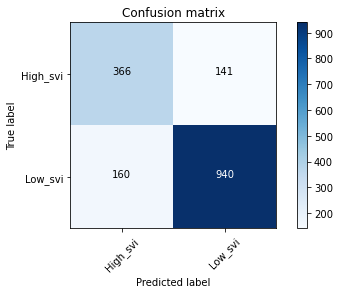

In [15]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [16]:
results = km.results(y_real, y_predict, binary=True)

In [17]:
results

(0.8126944617299315,
 0.7218934911242604,
 0.6958174904942965,
 0.7086156824782188)

In [18]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [19]:
auc(fpr, tpr)

0.8805791644253184

Text(0.5, 1.0, 'ROC curve')

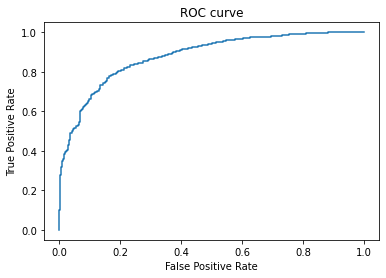

In [20]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [21]:
results_list = []
for i in range (1,11):
    for j in range (1, 11):
        X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
        X_normalize, Y_normalize, scalers = km.normalize(X, Y)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
        model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)
        Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
        y_predict = np.rint(Yhat).astype(int)
        y_real = Ytest.astype(int)
        results_list.append(km.results(y_real, y_predict))
    


100%|██████████| 1/1 [00:00<00:00, 335.57it/s]


Epoch 1/3
12854/12854 [==============================] - 5s 400us/step - loss: 0.6408
Epoch 2/3
12854/12854 [==============================] - 4s 282us/step - loss: 0.6080
Epoch 3/3
12854/12854 [==============================] - 4s 285us/step - loss: 0.5880


100%|██████████| 1/1 [00:00<00:00, 259.47it/s]


Epoch 1/3
12851/12851 [==============================] - 5s 409us/step - loss: 0.6437
Epoch 2/3
12851/12851 [==============================] - 4s 285us/step - loss: 0.6168
Epoch 3/3
12851/12851 [==============================] - 4s 288us/step - loss: 0.6026


100%|██████████| 1/1 [00:00<00:00, 355.39it/s]


Epoch 1/3
12848/12848 [==============================] - 5s 392us/step - loss: 0.6360
Epoch 2/3
12848/12848 [==============================] - 4s 287us/step - loss: 0.6078
Epoch 3/3
12848/12848 [==============================] - 4s 287us/step - loss: 0.5898


100%|██████████| 1/1 [00:00<00:00, 261.44it/s]


Epoch 1/3
12844/12844 [==============================] - 5s 387us/step - loss: 0.6399
Epoch 2/3
12844/12844 [==============================] - 4s 280us/step - loss: 0.6140
Epoch 3/3
12844/12844 [==============================] - 4s 281us/step - loss: 0.5995


100%|██████████| 1/1 [00:00<00:00, 242.84it/s]


Epoch 1/3
12841/12841 [==============================] - 5s 392us/step - loss: 0.6447
Epoch 2/3
12841/12841 [==============================] - 4s 310us/step - loss: 0.6143
Epoch 3/3
12841/12841 [==============================] - 4s 291us/step - loss: 0.6005


100%|██████████| 1/1 [00:00<00:00, 243.01it/s]


Epoch 1/3
12838/12838 [==============================] - 5s 394us/step - loss: 0.6465
Epoch 2/3
12838/12838 [==============================] - 4s 280us/step - loss: 0.6163
Epoch 3/3
12838/12838 [==============================] - 4s 280us/step - loss: 0.6039


100%|██████████| 1/1 [00:00<00:00, 231.82it/s]


Epoch 1/3
12835/12835 [==============================] - 5s 397us/step - loss: 0.6529
Epoch 2/3
12835/12835 [==============================] - 4s 283us/step - loss: 0.6183
Epoch 3/3
12835/12835 [==============================] - 4s 284us/step - loss: 0.6086


100%|██████████| 1/1 [00:00<00:00, 238.10it/s]


Epoch 1/3
12832/12832 [==============================] - 5s 388us/step - loss: 0.6470
Epoch 2/3
12832/12832 [==============================] - 4s 278us/step - loss: 0.6165
Epoch 3/3
12832/12832 [==============================] - 4s 278us/step - loss: 0.6062


100%|██████████| 1/1 [00:00<00:00, 303.85it/s]


Epoch 1/3
12828/12828 [==============================] - 5s 388us/step - loss: 0.6439
Epoch 2/3
12828/12828 [==============================] - 4s 279us/step - loss: 0.6180
Epoch 3/3
12828/12828 [==============================] - 4s 279us/step - loss: 0.6100


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 244.32it/s]


Epoch 1/3
12825/12825 [==============================] - 5s 393us/step - loss: 0.6502
Epoch 2/3
12825/12825 [==============================] - 4s 280us/step - loss: 0.6183
Epoch 3/3
12825/12825 [==============================] - 4s 285us/step - loss: 0.6115


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 2/2 [00:00<00:00, 277.27it/s]


Epoch 1/3
12851/12851 [==============================] - 6s 480us/step - loss: 0.6304
Epoch 2/3
12851/12851 [==============================] - 5s 370us/step - loss: 0.5940
Epoch 3/3
12851/12851 [==============================] - 5s 370us/step - loss: 0.5452


100%|██████████| 2/2 [00:00<00:00, 255.13it/s]


Epoch 1/3
12848/12848 [==============================] - 6s 476us/step - loss: 0.6393
Epoch 2/3
12848/12848 [==============================] - 5s 366us/step - loss: 0.6058
Epoch 3/3
12848/12848 [==============================] - 5s 366us/step - loss: 0.5751


100%|██████████| 2/2 [00:00<00:00, 290.48it/s]


Epoch 1/3
12844/12844 [==============================] - 6s 480us/step - loss: 0.6369
Epoch 2/3
12844/12844 [==============================] - 5s 412us/step - loss: 0.6086
Epoch 3/3
12844/12844 [==============================] - 5s 373us/step - loss: 0.5852


100%|██████████| 2/2 [00:00<00:00, 290.45it/s]


Epoch 1/3
12841/12841 [==============================] - 6s 486us/step - loss: 0.6387
Epoch 2/3
12841/12841 [==============================] - 5s 372us/step - loss: 0.6098
Epoch 3/3
12841/12841 [==============================] - 5s 366us/step - loss: 0.5858


100%|██████████| 2/2 [00:00<00:00, 290.05it/s]


Epoch 1/3
12838/12838 [==============================] - 6s 489us/step - loss: 0.6387
Epoch 2/3
12838/12838 [==============================] - 5s 368us/step - loss: 0.6093
Epoch 3/3
12838/12838 [==============================] - 5s 368us/step - loss: 0.5928


100%|██████████| 2/2 [00:00<00:00, 292.75it/s]


Epoch 1/3
12835/12835 [==============================] - 6s 473us/step - loss: 0.6428
Epoch 2/3
12835/12835 [==============================] - 5s 365us/step - loss: 0.6084
Epoch 3/3
12835/12835 [==============================] - 5s 366us/step - loss: 0.5864


100%|██████████| 2/2 [00:00<00:00, 294.38it/s]


Epoch 1/3
12832/12832 [==============================] - 6s 480us/step - loss: 0.6387
Epoch 2/3
12832/12832 [==============================] - 5s 366us/step - loss: 0.6057
Epoch 3/3
12832/12832 [==============================] - 5s 367us/step - loss: 0.5860


100%|██████████| 2/2 [00:00<00:00, 296.25it/s]


Epoch 1/3
12828/12828 [==============================] - 6s 470us/step - loss: 0.6391
Epoch 2/3
12828/12828 [==============================] - 5s 371us/step - loss: 0.6124
Epoch 3/3
12828/12828 [==============================] - 5s 372us/step - loss: 0.6003


100%|██████████| 2/2 [00:00<00:00, 278.43it/s]


Epoch 1/3
12825/12825 [==============================] - 6s 483us/step - loss: 0.6392
Epoch 2/3
12825/12825 [==============================] - 5s 367us/step - loss: 0.6077
Epoch 3/3
12825/12825 [==============================] - 5s 368us/step - loss: 0.5906


100%|██████████| 2/2 [00:00<00:00, 260.61it/s]


Epoch 1/3
12822/12822 [==============================] - 6s 494us/step - loss: 0.6377
Epoch 2/3
12822/12822 [==============================] - 5s 391us/step - loss: 0.6132
Epoch 3/3
12822/12822 [==============================] - 5s 370us/step - loss: 0.6009


100%|██████████| 3/3 [00:00<00:00, 279.40it/s]


Epoch 1/3
12848/12848 [==============================] - 7s 567us/step - loss: 0.6285
Epoch 2/3
12848/12848 [==============================] - 6s 452us/step - loss: 0.5896
Epoch 3/3
12848/12848 [==============================] - 6s 451us/step - loss: 0.5086


100%|██████████| 3/3 [00:00<00:00, 267.59it/s]


Epoch 1/3
12844/12844 [==============================] - 7s 564us/step - loss: 0.6299
Epoch 2/3
12844/12844 [==============================] - 6s 461us/step - loss: 0.5924
Epoch 3/3
12844/12844 [==============================] - 6s 452us/step - loss: 0.5299


100%|██████████| 3/3 [00:00<00:00, 286.67it/s]


Epoch 1/3
12841/12841 [==============================] - 7s 563us/step - loss: 0.6326
Epoch 2/3
12841/12841 [==============================] - 6s 457us/step - loss: 0.5864
Epoch 3/3
12841/12841 [==============================] - 6s 458us/step - loss: 0.5269


100%|██████████| 3/3 [00:00<00:00, 287.89it/s]


Epoch 1/3
12838/12838 [==============================] - 7s 578us/step - loss: 0.6281
Epoch 2/3
12838/12838 [==============================] - 6s 457us/step - loss: 0.5982
Epoch 3/3
12838/12838 [==============================] - 6s 456us/step - loss: 0.5656


100%|██████████| 3/3 [00:00<00:00, 285.53it/s]


Epoch 1/3
12835/12835 [==============================] - 7s 564us/step - loss: 0.6410
Epoch 2/3
12835/12835 [==============================] - 6s 457us/step - loss: 0.5943
Epoch 3/3
12835/12835 [==============================] - 6s 457us/step - loss: 0.5514


100%|██████████| 3/3 [00:00<00:00, 285.09it/s]


Epoch 1/3
12832/12832 [==============================] - 8s 609us/step - loss: 0.6323
Epoch 2/3
12832/12832 [==============================] - 6s 463us/step - loss: 0.6058
Epoch 3/3
12832/12832 [==============================] - 6s 463us/step - loss: 0.5715


100%|██████████| 3/3 [00:00<00:00, 286.02it/s]


Epoch 1/3
12828/12828 [==============================] - 7s 561us/step - loss: 0.6320
Epoch 2/3
12828/12828 [==============================] - 6s 455us/step - loss: 0.6013
Epoch 3/3
12828/12828 [==============================] - 6s 455us/step - loss: 0.5652


100%|██████████| 3/3 [00:00<00:00, 278.48it/s]


Epoch 1/3
12825/12825 [==============================] - 7s 568us/step - loss: 0.6293
Epoch 2/3
12825/12825 [==============================] - 6s 478us/step - loss: 0.6051
Epoch 3/3
12825/12825 [==============================] - 6s 456us/step - loss: 0.5874


100%|██████████| 3/3 [00:00<00:00, 285.06it/s]


Epoch 1/3
12822/12822 [==============================] - 8s 625us/step - loss: 0.6377
Epoch 2/3
12822/12822 [==============================] - 6s 472us/step - loss: 0.6112
Epoch 3/3
12822/12822 [==============================] - 6s 461us/step - loss: 0.5956


100%|██████████| 3/3 [00:00<00:00, 285.34it/s]


Epoch 1/3
12819/12819 [==============================] - 7s 567us/step - loss: 0.6315
Epoch 2/3
12819/12819 [==============================] - 6s 456us/step - loss: 0.6028
Epoch 3/3
12819/12819 [==============================] - 6s 455us/step - loss: 0.5786


100%|██████████| 4/4 [00:00<00:00, 184.69it/s]


Epoch 1/3
12844/12844 [==============================] - 8s 655us/step - loss: 0.6375
Epoch 2/3
12844/12844 [==============================] - 8s 584us/step - loss: 0.5879
Epoch 3/3
12844/12844 [==============================] - 7s 545us/step - loss: 0.4919


100%|██████████| 4/4 [00:00<00:00, 252.35it/s]


Epoch 1/3
12841/12841 [==============================] - 8s 654us/step - loss: 0.6301
Epoch 2/3
12841/12841 [==============================] - 7s 541us/step - loss: 0.5752
Epoch 3/3
12841/12841 [==============================] - 7s 556us/step - loss: 0.4935


100%|██████████| 4/4 [00:00<00:00, 101.97it/s]


Epoch 1/3
12838/12838 [==============================] - 22s 2ms/step - loss: 0.6276
Epoch 2/3
12838/12838 [==============================] - 43s 3ms/step - loss: 0.5929
Epoch 3/3
12838/12838 [==============================] - 50s 4ms/step - loss: 0.5283


100%|██████████| 4/4 [00:00<00:00, 69.48it/s]


Epoch 1/3
12835/12835 [==============================] - 45s 3ms/step - loss: 0.6332
Epoch 2/3
12835/12835 [==============================] - 39s 3ms/step - loss: 0.5904
Epoch 3/3
12835/12835 [==============================] - 38s 3ms/step - loss: 0.5249


100%|██████████| 4/4 [00:00<00:00, 55.65it/s]


Epoch 1/3
12832/12832 [==============================] - 40s 3ms/step - loss: 0.6276
Epoch 2/3
12832/12832 [==============================] - 34s 3ms/step - loss: 0.5902
Epoch 3/3
12832/12832 [==============================] - 30s 2ms/step - loss: 0.5278


100%|██████████| 4/4 [00:00<00:00, 106.80it/s]


Epoch 1/3
12828/12828 [==============================] - 35s 3ms/step - loss: 0.6304
Epoch 2/3
12828/12828 [==============================] - 31s 2ms/step - loss: 0.5906
Epoch 3/3
12828/12828 [==============================] - 33s 3ms/step - loss: 0.5383


100%|██████████| 4/4 [00:00<00:00, 84.68it/s]


Epoch 1/3
12825/12825 [==============================] - 37s 3ms/step - loss: 0.6296
Epoch 2/3
12825/12825 [==============================] - 31s 2ms/step - loss: 0.5958
Epoch 3/3
12825/12825 [==============================] - 31s 2ms/step - loss: 0.5519


100%|██████████| 4/4 [00:00<00:00, 94.69it/s]


Epoch 1/3
12822/12822 [==============================] - 33s 3ms/step - loss: 0.6273
Epoch 2/3
12822/12822 [==============================] - 27s 2ms/step - loss: 0.6013
Epoch 3/3
12822/12822 [==============================] - 29s 2ms/step - loss: 0.5712


100%|██████████| 4/4 [00:00<00:00, 80.86it/s]


Epoch 1/3
12819/12819 [==============================] - 31s 2ms/step - loss: 0.6301
Epoch 2/3
12819/12819 [==============================] - 25s 2ms/step - loss: 0.5946
Epoch 3/3
12819/12819 [==============================] - 26s 2ms/step - loss: 0.5527


100%|██████████| 4/4 [00:00<00:00, 120.84it/s]


Epoch 1/3
12816/12816 [==============================] - 29s 2ms/step - loss: 0.6316
Epoch 2/3
12816/12816 [==============================] - 27s 2ms/step - loss: 0.6041
Epoch 3/3
12816/12816 [==============================] - 25s 2ms/step - loss: 0.5751


100%|██████████| 5/5 [00:00<00:00, 104.00it/s]


Epoch 1/3
12841/12841 [==============================] - 38s 3ms/step - loss: 0.6261
Epoch 2/3
12841/12841 [==============================] - 34s 3ms/step - loss: 0.5690
Epoch 3/3
12841/12841 [==============================] - 34s 3ms/step - loss: 0.4766


100%|██████████| 5/5 [00:00<00:00, 61.95it/s]


Epoch 1/3
12838/12838 [==============================] - 37s 3ms/step - loss: 0.6265
Epoch 2/3
12838/12838 [==============================] - 34s 3ms/step - loss: 0.5806
Epoch 3/3
12838/12838 [==============================] - 34s 3ms/step - loss: 0.5085


100%|██████████| 5/5 [00:00<00:00, 81.70it/s]


Epoch 1/3
12835/12835 [==============================] - 40s 3ms/step - loss: 0.6308
Epoch 2/3
12835/12835 [==============================] - 32s 3ms/step - loss: 0.5826
Epoch 3/3
12835/12835 [==============================] - 32s 2ms/step - loss: 0.5081


100%|██████████| 5/5 [00:00<00:00, 91.92it/s]


Epoch 1/3
12832/12832 [==============================] - 38s 3ms/step - loss: 0.6312
Epoch 2/3
12832/12832 [==============================] - 33s 3ms/step - loss: 0.5921
Epoch 3/3
12832/12832 [==============================] - 33s 3ms/step - loss: 0.5185


100%|██████████| 5/5 [00:00<00:00, 90.60it/s]


Epoch 1/3
12828/12828 [==============================] - 38s 3ms/step - loss: 0.6314
Epoch 2/3
12828/12828 [==============================] - 34s 3ms/step - loss: 0.5767
Epoch 3/3
12828/12828 [==============================] - 35s 3ms/step - loss: 0.5110


100%|██████████| 5/5 [00:00<00:00, 101.68it/s]


Epoch 1/3
12825/12825 [==============================] - 39s 3ms/step - loss: 0.6278
Epoch 2/3
12825/12825 [==============================] - 18s 1ms/step - loss: 0.5859
Epoch 3/3
12825/12825 [==============================] - 10s 813us/step - loss: 0.5307


100%|██████████| 5/5 [00:00<00:00, 207.30it/s]


Epoch 1/3
12822/12822 [==============================] - 11s 822us/step - loss: 0.6303
Epoch 2/3
12822/12822 [==============================] - 9s 703us/step - loss: 0.5885
Epoch 3/3
12822/12822 [==============================] - 8s 655us/step - loss: 0.5302


100%|██████████| 5/5 [00:00<00:00, 192.00it/s]


Epoch 1/3
12819/12819 [==============================] - 10s 814us/step - loss: 0.6289
Epoch 2/3
12819/12819 [==============================] - 9s 672us/step - loss: 0.5900
Epoch 3/3
12819/12819 [==============================] - 9s 669us/step - loss: 0.5356


100%|██████████| 5/5 [00:00<00:00, 217.69it/s]


Epoch 1/3
12816/12816 [==============================] - 10s 774us/step - loss: 0.6295
Epoch 2/3
12816/12816 [==============================] - 8s 656us/step - loss: 0.6006
Epoch 3/3
12816/12816 [==============================] - 8s 650us/step - loss: 0.5624


100%|██████████| 5/5 [00:00<00:00, 217.36it/s]


Epoch 1/3
12812/12812 [==============================] - 11s 820us/step - loss: 0.6350
Epoch 2/3
12812/12812 [==============================] - 8s 659us/step - loss: 0.6056
Epoch 3/3
12812/12812 [==============================] - 9s 665us/step - loss: 0.5818


100%|██████████| 6/6 [00:00<00:00, 188.54it/s]


Epoch 1/3
12838/12838 [==============================] - 11s 868us/step - loss: 0.6261
Epoch 2/3
12838/12838 [==============================] - 10s 761us/step - loss: 0.5622
Epoch 3/3
12838/12838 [==============================] - 10s 762us/step - loss: 0.4723


100%|██████████| 6/6 [00:00<00:00, 195.62it/s]


Epoch 1/3
12835/12835 [==============================] - 11s 850us/step - loss: 0.6259
Epoch 2/3
12835/12835 [==============================] - 9s 737us/step - loss: 0.5655
Epoch 3/3
12835/12835 [==============================] - 9s 740us/step - loss: 0.4814


100%|██████████| 6/6 [00:00<00:00, 210.60it/s]


Epoch 1/3
12832/12832 [==============================] - 11s 855us/step - loss: 0.6303
Epoch 2/3
12832/12832 [==============================] - 10s 747us/step - loss: 0.5878
Epoch 3/3
12832/12832 [==============================] - 10s 787us/step - loss: 0.5045


100%|██████████| 6/6 [00:00<00:00, 190.01it/s]


Epoch 1/3
12828/12828 [==============================] - 11s 845us/step - loss: 0.6264
Epoch 2/3
12828/12828 [==============================] - 9s 737us/step - loss: 0.5613
Epoch 3/3
12828/12828 [==============================] - 10s 760us/step - loss: 0.4951


100%|██████████| 6/6 [00:00<00:00, 218.29it/s]


Epoch 1/3
12825/12825 [==============================] - 11s 856us/step - loss: 0.6239
Epoch 2/3
12825/12825 [==============================] - 9s 736us/step - loss: 0.5797
Epoch 3/3
12825/12825 [==============================] - 10s 751us/step - loss: 0.5205


100%|██████████| 6/6 [00:00<00:00, 201.09it/s]


Epoch 1/3
12822/12822 [==============================] - 11s 873us/step - loss: 0.6349
Epoch 2/3
12822/12822 [==============================] - 10s 766us/step - loss: 0.5989
Epoch 3/3
12822/12822 [==============================] - 10s 760us/step - loss: 0.5458


100%|██████████| 6/6 [00:00<00:00, 186.59it/s]


Epoch 1/3
12819/12819 [==============================] - 12s 911us/step - loss: 0.6247
Epoch 2/3
12819/12819 [==============================] - 10s 744us/step - loss: 0.5789
Epoch 3/3
12819/12819 [==============================] - 10s 750us/step - loss: 0.5323


100%|██████████| 6/6 [00:00<00:00, 213.02it/s]


Epoch 1/3
12816/12816 [==============================] - 11s 853us/step - loss: 0.6367
Epoch 2/3
12816/12816 [==============================] - 9s 734us/step - loss: 0.6015
Epoch 3/3
12816/12816 [==============================] - 9s 738us/step - loss: 0.5503


100%|██████████| 6/6 [00:00<00:00, 206.44it/s]


Epoch 1/3
12812/12812 [==============================] - 11s 845us/step - loss: 0.6252
Epoch 2/3
12812/12812 [==============================] - 9s 729us/step - loss: 0.5892
Epoch 3/3
12812/12812 [==============================] - 9s 738us/step - loss: 0.5515


100%|██████████| 6/6 [00:00<00:00, 207.70it/s]


Epoch 1/3
12809/12809 [==============================] - 11s 883us/step - loss: 0.6276
Epoch 2/3
12809/12809 [==============================] - 10s 755us/step - loss: 0.5996
Epoch 3/3
12809/12809 [==============================] - 10s 807us/step - loss: 0.5679


100%|██████████| 7/7 [00:00<00:00, 211.83it/s]


Epoch 1/3
12835/12835 [==============================] - 12s 963us/step - loss: 0.6284
Epoch 2/3
12835/12835 [==============================] - 11s 850us/step - loss: 0.5443
Epoch 3/3
12835/12835 [==============================] - 12s 906us/step - loss: 0.4708


100%|██████████| 7/7 [00:00<00:00, 199.17it/s]


Epoch 1/3
12832/12832 [==============================] - 12s 944us/step - loss: 0.6242
Epoch 2/3
12832/12832 [==============================] - 11s 833us/step - loss: 0.5803
Epoch 3/3
12832/12832 [==============================] - 11s 870us/step - loss: 0.5019


100%|██████████| 7/7 [00:00<00:00, 195.89it/s]


Epoch 1/3
12828/12828 [==============================] - 12s 940us/step - loss: 0.6188
Epoch 2/3
12828/12828 [==============================] - 11s 846us/step - loss: 0.5328
Epoch 3/3
12828/12828 [==============================] - 11s 880us/step - loss: 0.4872


100%|██████████| 7/7 [00:00<00:00, 192.20it/s]


Epoch 1/3
12825/12825 [==============================] - 12s 935us/step - loss: 0.6242
Epoch 2/3
12825/12825 [==============================] - 11s 822us/step - loss: 0.5678
Epoch 3/3
12825/12825 [==============================] - 11s 825us/step - loss: 0.5042


100%|██████████| 7/7 [00:00<00:00, 202.59it/s]


Epoch 1/3
12822/12822 [==============================] - 12s 936us/step - loss: 0.6330
Epoch 2/3
12822/12822 [==============================] - 11s 827us/step - loss: 0.5856
Epoch 3/3
12822/12822 [==============================] - 11s 838us/step - loss: 0.5242


100%|██████████| 7/7 [00:00<00:00, 203.18it/s]


Epoch 1/3
12819/12819 [==============================] - 12s 939us/step - loss: 0.6233
Epoch 2/3
12819/12819 [==============================] - 11s 835us/step - loss: 0.5642
Epoch 3/3
12819/12819 [==============================] - 11s 824us/step - loss: 0.5101


100%|██████████| 7/7 [00:00<00:00, 177.74it/s]


Epoch 1/3
12816/12816 [==============================] - 12s 931us/step - loss: 0.6301
Epoch 2/3
12816/12816 [==============================] - 11s 840us/step - loss: 0.5911
Epoch 3/3
12816/12816 [==============================] - 11s 830us/step - loss: 0.5440


100%|██████████| 7/7 [00:00<00:00, 210.76it/s]


Epoch 1/3
12812/12812 [==============================] - 12s 948us/step - loss: 0.6267
Epoch 2/3
12812/12812 [==============================] - 11s 887us/step - loss: 0.5831
Epoch 3/3
12812/12812 [==============================] - 12s 899us/step - loss: 0.5391


100%|██████████| 7/7 [00:00<00:00, 198.68it/s]


Epoch 1/3
12809/12809 [==============================] - 15s 1ms/step - loss: 0.6255
Epoch 2/3
12809/12809 [==============================] - 11s 873us/step - loss: 0.5828
Epoch 3/3
12809/12809 [==============================] - 11s 848us/step - loss: 0.5418


100%|██████████| 7/7 [00:00<00:00, 279.73it/s]


Epoch 1/3
12806/12806 [==============================] - 13s 1ms/step - loss: 0.6334
Epoch 2/3
12806/12806 [==============================] - 11s 880us/step - loss: 0.5980
Epoch 3/3
12806/12806 [==============================] - 11s 876us/step - loss: 0.5535


100%|██████████| 8/8 [00:00<00:00, 158.40it/s]


Epoch 1/3
12832/12832 [==============================] - 14s 1ms/step - loss: 0.6190
Epoch 2/3
12832/12832 [==============================] - 12s 953us/step - loss: 0.5532
Epoch 3/3
12832/12832 [==============================] - 12s 949us/step - loss: 0.4821


100%|██████████| 8/8 [00:00<00:00, 172.28it/s]


Epoch 1/3
12828/12828 [==============================] - 14s 1ms/step - loss: 0.6168
Epoch 2/3
12828/12828 [==============================] - 12s 952us/step - loss: 0.5597
Epoch 3/3
12828/12828 [==============================] - 12s 973us/step - loss: 0.4863


100%|██████████| 8/8 [00:00<00:00, 182.65it/s]


Epoch 1/3
12825/12825 [==============================] - 14s 1ms/step - loss: 0.6247
Epoch 2/3
12825/12825 [==============================] - 12s 972us/step - loss: 0.5792
Epoch 3/3
12825/12825 [==============================] - 12s 926us/step - loss: 0.5100


100%|██████████| 8/8 [00:00<00:00, 175.19it/s]


Epoch 1/3
12822/12822 [==============================] - 14s 1ms/step - loss: 0.6271
Epoch 2/3
12822/12822 [==============================] - 12s 945us/step - loss: 0.5663
Epoch 3/3
12822/12822 [==============================] - 12s 906us/step - loss: 0.5115


100%|██████████| 8/8 [00:00<00:00, 171.40it/s]


Epoch 1/3
12819/12819 [==============================] - 13s 1ms/step - loss: 0.6220
Epoch 2/3
12819/12819 [==============================] - 13s 1ms/step - loss: 0.5689
Epoch 3/3
12819/12819 [==============================] - 13s 981us/step - loss: 0.5156


100%|██████████| 8/8 [00:00<00:00, 122.09it/s]


Epoch 1/3
12816/12816 [==============================] - 14s 1ms/step - loss: 0.6242
Epoch 2/3
12816/12816 [==============================] - 12s 921us/step - loss: 0.5799
Epoch 3/3
12816/12816 [==============================] - 12s 946us/step - loss: 0.5160


100%|██████████| 8/8 [00:00<00:00, 170.59it/s]


Epoch 1/3
12812/12812 [==============================] - 13s 1ms/step - loss: 0.6304
Epoch 2/3
12812/12812 [==============================] - 12s 918us/step - loss: 0.5997
Epoch 3/3
12812/12812 [==============================] - 12s 915us/step - loss: 0.5595


100%|██████████| 8/8 [00:00<00:00, 169.56it/s]


Epoch 1/3
12809/12809 [==============================] - 14s 1ms/step - loss: 0.6290
Epoch 2/3
12809/12809 [==============================] - 12s 915us/step - loss: 0.6017
Epoch 3/3
12809/12809 [==============================] - 12s 903us/step - loss: 0.5586


100%|██████████| 8/8 [00:00<00:00, 173.80it/s]


Epoch 1/3
12806/12806 [==============================] - 13s 1ms/step - loss: 0.6230
Epoch 2/3
12806/12806 [==============================] - 12s 915us/step - loss: 0.5923
Epoch 3/3
12806/12806 [==============================] - 12s 905us/step - loss: 0.5513


100%|██████████| 8/8 [00:00<00:00, 176.58it/s]


Epoch 1/3
12803/12803 [==============================] - 13s 1ms/step - loss: 0.6313
Epoch 2/3
12803/12803 [==============================] - 12s 899us/step - loss: 0.6006
Epoch 3/3
12803/12803 [==============================] - 12s 910us/step - loss: 0.5672


100%|██████████| 9/9 [00:00<00:00, 275.37it/s]


Epoch 1/3
12828/12828 [==============================] - 15s 1ms/step - loss: 0.6232
Epoch 2/3
12828/12828 [==============================] - 13s 996us/step - loss: 0.5467
Epoch 3/3
12828/12828 [==============================] - 13s 989us/step - loss: 0.4755


100%|██████████| 9/9 [00:00<00:00, 263.38it/s]


Epoch 1/3
12825/12825 [==============================] - 15s 1ms/step - loss: 0.6284
Epoch 2/3
12825/12825 [==============================] - 14s 1ms/step - loss: 0.5851
Epoch 3/3
12825/12825 [==============================] - 13s 992us/step - loss: 0.5126


100%|██████████| 9/9 [00:00<00:00, 251.09it/s]


Epoch 1/3
12822/12822 [==============================] - 15s 1ms/step - loss: 0.6163
Epoch 2/3
12822/12822 [==============================] - 14s 1ms/step - loss: 0.5276
Epoch 3/3
12822/12822 [==============================] - 14s 1ms/step - loss: 0.4928


100%|██████████| 9/9 [00:00<00:00, 235.29it/s]


Epoch 1/3
12819/12819 [==============================] - 14s 1ms/step - loss: 0.6260
Epoch 2/3
12819/12819 [==============================] - 13s 991us/step - loss: 0.5470
Epoch 3/3
12819/12819 [==============================] - 12s 973us/step - loss: 0.5015


100%|██████████| 9/9 [00:00<00:00, 283.84it/s]


Epoch 1/3
12816/12816 [==============================] - 14s 1ms/step - loss: 0.6167
Epoch 2/3
12816/12816 [==============================] - 13s 1ms/step - loss: 0.5636
Epoch 3/3
12816/12816 [==============================] - 13s 990us/step - loss: 0.5130


100%|██████████| 9/9 [00:00<00:00, 232.83it/s]


Epoch 1/3
12812/12812 [==============================] - 14s 1ms/step - loss: 0.6309
Epoch 2/3
12812/12812 [==============================] - 13s 1ms/step - loss: 0.5820
Epoch 3/3
12812/12812 [==============================] - 13s 1ms/step - loss: 0.5314


100%|██████████| 9/9 [00:00<00:00, 229.44it/s]


Epoch 1/3
12809/12809 [==============================] - 16s 1ms/step - loss: 0.6220
Epoch 2/3
12809/12809 [==============================] - 13s 1ms/step - loss: 0.5664
Epoch 3/3
12809/12809 [==============================] - 14s 1ms/step - loss: 0.5264


100%|██████████| 9/9 [00:00<00:00, 230.34it/s]


Epoch 1/3
12806/12806 [==============================] - 14s 1ms/step - loss: 0.6280
Epoch 2/3
12806/12806 [==============================] - 14s 1ms/step - loss: 0.5972
Epoch 3/3
12806/12806 [==============================] - 13s 1ms/step - loss: 0.5571


100%|██████████| 9/9 [00:00<00:00, 300.41it/s]


Epoch 1/3
12803/12803 [==============================] - 14s 1ms/step - loss: 0.6309
Epoch 2/3
12803/12803 [==============================] - 13s 1ms/step - loss: 0.5844
Epoch 3/3
12803/12803 [==============================] - 13s 996us/step - loss: 0.5431


100%|██████████| 9/9 [00:00<00:00, 227.55it/s]


Epoch 1/3
12800/12800 [==============================] - 17s 1ms/step - loss: 0.6300
Epoch 2/3
12800/12800 [==============================] - 13s 1ms/step - loss: 0.5908
Epoch 3/3
12800/12800 [==============================] - 13s 1ms/step - loss: 0.5461


100%|██████████| 10/10 [00:00<00:00, 248.71it/s]


Epoch 1/3
12825/12825 [==============================] - 15s 1ms/step - loss: 0.6206
Epoch 2/3
12825/12825 [==============================] - 15s 1ms/step - loss: 0.5305
Epoch 3/3
12825/12825 [==============================] - 14s 1ms/step - loss: 0.4749


100%|██████████| 10/10 [00:00<00:00, 250.57it/s]


Epoch 1/3
12822/12822 [==============================] - 15s 1ms/step - loss: 0.6199
Epoch 2/3
12822/12822 [==============================] - 14s 1ms/step - loss: 0.5465
Epoch 3/3
12822/12822 [==============================] - 14s 1ms/step - loss: 0.4986


100%|██████████| 10/10 [00:00<00:00, 252.90it/s]


Epoch 1/3
12819/12819 [==============================] - 15s 1ms/step - loss: 0.6288
Epoch 2/3
12819/12819 [==============================] - 14s 1ms/step - loss: 0.5863
Epoch 3/3
12819/12819 [==============================] - 14s 1ms/step - loss: 0.5148


100%|██████████| 10/10 [00:00<00:00, 253.42it/s]


Epoch 1/3
12816/12816 [==============================] - 15s 1ms/step - loss: 0.6278
Epoch 2/3
12816/12816 [==============================] - 14s 1ms/step - loss: 0.5639
Epoch 3/3
12816/12816 [==============================] - 14s 1ms/step - loss: 0.5112


100%|██████████| 10/10 [00:00<00:00, 195.51it/s]


Epoch 1/3
12812/12812 [==============================] - 15s 1ms/step - loss: 0.6219
Epoch 2/3
12812/12812 [==============================] - 14s 1ms/step - loss: 0.5543
Epoch 3/3
12812/12812 [==============================] - 14s 1ms/step - loss: 0.5166


100%|██████████| 10/10 [00:00<00:00, 244.44it/s]


Epoch 1/3
12809/12809 [==============================] - 16s 1ms/step - loss: 0.6327
Epoch 2/3
12809/12809 [==============================] - 14s 1ms/step - loss: 0.5813
Epoch 3/3
12809/12809 [==============================] - 14s 1ms/step - loss: 0.5277


100%|██████████| 10/10 [00:00<00:00, 189.76it/s]


Epoch 1/3
12806/12806 [==============================] - 15s 1ms/step - loss: 0.6268
Epoch 2/3
12806/12806 [==============================] - 14s 1ms/step - loss: 0.5891
Epoch 3/3
12806/12806 [==============================] - 14s 1ms/step - loss: 0.5412


100%|██████████| 10/10 [00:00<00:00, 227.95it/s]


Epoch 1/3
12803/12803 [==============================] - 15s 1ms/step - loss: 0.6257
Epoch 2/3
12803/12803 [==============================] - 14s 1ms/step - loss: 0.5833
Epoch 3/3
12803/12803 [==============================] - 14s 1ms/step - loss: 0.5391


100%|██████████| 10/10 [00:00<00:00, 314.91it/s]


Epoch 1/3
12800/12800 [==============================] - 15s 1ms/step - loss: 0.6219
Epoch 2/3
12800/12800 [==============================] - 14s 1ms/step - loss: 0.5837
Epoch 3/3
12800/12800 [==============================] - 14s 1ms/step - loss: 0.5379


100%|██████████| 10/10 [00:00<00:00, 185.31it/s]


Epoch 1/3
12796/12796 [==============================] - 15s 1ms/step - loss: 0.6256
Epoch 2/3
12796/12796 [==============================] - 14s 1ms/step - loss: 0.6002
Epoch 3/3
12796/12796 [==============================] - 14s 1ms/step - loss: 0.5592


In [22]:
(unique, counts) = np.unique(ytrain, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [23]:
frequencies

array([[0.000e+00, 4.161e+03],
       [1.000e+00, 8.635e+03]])

In [30]:
#plot graph of a metric result for all n_step_in and n_step_out values
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(4):
    for i in range(10):
        y=[]
        for j in range (10):
            y.append(results_list[i*10:i*10+10][j][z])
        plt.plot(x, y, label=f'n_steps_in={i+1}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel(label[z])
    plt.title("Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
    plt.savefig(f"figures/Simple LSTM {label[z]}.png", bbox_inches="tight")
    plt.close()

IndexError: tuple index out of range

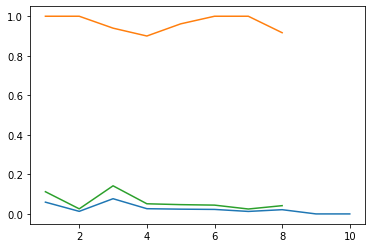

In [25]:
#plot graph of all metric results for a n_step_in value
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(10):
    for i in range(4):
        y=[]
        for j in range (10):
            y.append(results_list[z*10:z*10+10][j][i+1])
        plt.plot(x, y, label=label[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel('Metric value')
    plt.title(f"Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
    plt.savefig(f"figures/Simple LSTM n_steps_in={z+1}.png", bbox_inches="tight")
    plt.close()